In [17]:
from all_imports import *

import _modules

from _modules.plotColors import *


In [13]:
filepath: str  = r"C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\Review\Review_dataset.csv"

#raw_data_df = pd.read_csv(filepath)
raw_data_df = pd.read_csv(filepath, encoding='ISO-8859-1')

raw_data_df = raw_data_df.dropna(subset=['Study_climateclassification'])
raw_data_df_overview_plot = raw_data_df[['Study_country', 'Study_latitude', 'Study_longitude', 'Study_climateclassification']].copy()
raw_data_df_overview_plot['number_of_points'] = 1

display(raw_data_df_overview_plot.head(5))

,Study_country,Study_latitude,Study_longitude,Study_climateclassification,number_of_points
0,United Kingdom,52.20576,0.119167,Cfb,1
1,Canada,45.50169,-73.567253,Dfb,1
2,Bangladesh,23.81030,90.412500,Am,1
3,Isreal,29.88030,35.057500,Bwh,1
4,Australia,-33.86880,151.209300,Cfa,1


## Text Map

Index(['ID', 'general_doi', 'general_date', 'general_publisher',
       'general_title', 'general_authors', 'Study_country', 'Study_City',
       'Study_climateclassification', 'Study_latitude', 'Study_longitude',
       'StudyType', 'Keywords', 'Study_Environment',
       'Study_Environment_description', 'Study_Season', 'Study_Period',
       'Study_TimeofDay', 'Study_QuestionnaireDesign_available',
       'Study_thermalsensation_scale', 'Study_meterological_design',
       'Study_NumberofSubjects', 'Study_NumberofVotes',
       'Study_Comfort_Indices', 'Study_Physiological_factors',
       'Study_Behavioral_factors', 'Study_Other_factors', 'Study_goal'],
      dtype='object')


0                                                    -
1                                                    -
2                 Tropics: Adaptation: Outdoor comfort
3    Bioclimatology: Hot and dry climate: Thermal s...
4    Thermal comfort: Outdoors: Semi-outdoors: Ther...
Name: Keywords, dtype: object

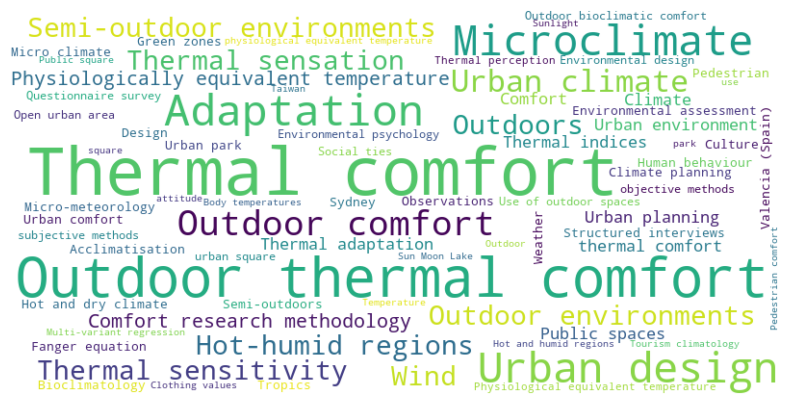

C:\Users\gottk\AppData\Local\Temp\ipykernel_29372\3626555494.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Keyword', data=keyword_df, palette='viridis')


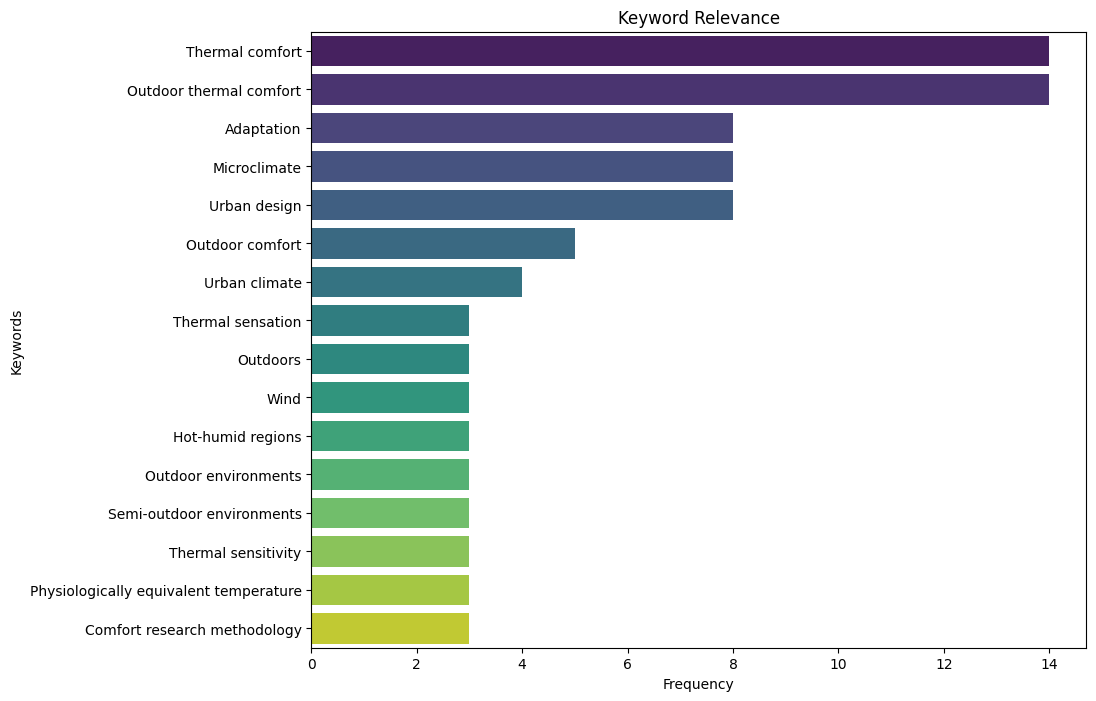

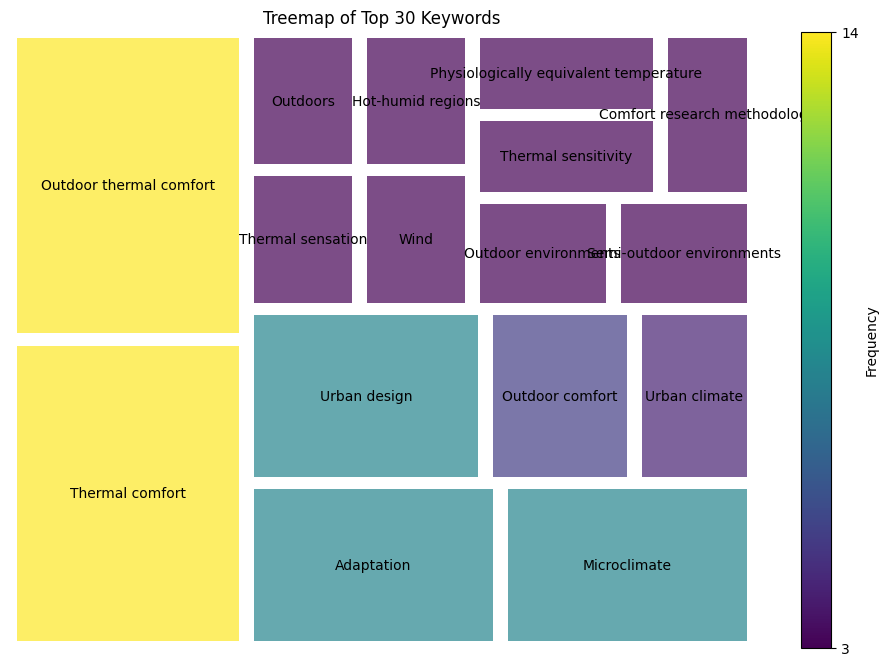

In [45]:

print(raw_data_df.columns)
display(raw_data_df["Keywords"].head(5))

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

filtered_df = raw_data_df[(raw_data_df['Keywords'].notna()) & (raw_data_df['Keywords'] != '-')]

# Step 2: Extract and split the keywords
keywords_series = filtered_df['Keywords'].str.split(':')
all_keywords = keywords_series.explode().str.strip()

# Step 3: Calculate the frequency of each keyword
keyword_frequencies = Counter(all_keywords)

# Step 4: Generate the word cloud with frequencies
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis',  # Use a colormap to differentiate
    max_words=75
).generate_from_frequencies(keyword_frequencies)

# Step 5: Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Convert to DataFrame and filter out items with frequency < 3
keyword_df = pd.DataFrame(keyword_frequencies.items(), columns=['Keyword', 'Frequency'])
keyword_df = keyword_df[keyword_df['Frequency'] >= 3].sort_values(by='Frequency', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x='Frequency', y='Keyword', data=keyword_df, palette='viridis')
plt.title('Keyword Relevance')
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.show()


import squarify

# Calculate keyword frequencies
keyword_frequencies = Counter(all_keywords)

# Convert to DataFrame and filter out items with frequency < 3
keyword_df = pd.DataFrame(keyword_frequencies.items(), columns=['Keyword', 'Frequency'])
keyword_df = keyword_df[keyword_df['Frequency'] >= 3].sort_values(by='Frequency', ascending=False)

# Select the top 30 keywords
top_keywords_df = keyword_df.head(30)

# Prepare data for treemap
sizes = top_keywords_df['Frequency']
labels = top_keywords_df['Keyword']

# Create the treemap plot
fig, ax = plt.subplots(figsize=(12, 8))
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(sizes), vmax=max(sizes))

# Plot treemap
rects = squarify.plot(sizes=sizes, alpha=.7, color=cmap(norm(sizes)), ax=ax, pad=1, label=labels)

# Add color legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for the legend
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Frequency')
cbar.set_ticks([min(sizes), max(sizes)])
cbar.set_ticklabels([f'{int(min(sizes))}', f'{int(max(sizes))}'])

plt.title('Treemap of Top 30 Keywords')
plt.axis('off')
plt.show()

## Study overview

In [3]:
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np

# Prepare data for clustering
coordinates = raw_data_df[['Study_longitude', 'Study_latitude']].values

# Define DBSCAN parameters
eps = 1  # Maximum distance for two points to be considered as in the same neighborhood
min_samples = 1  # Allow clusters to form with even a single point

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)

# Add cluster labels to the DataFrame
raw_data_df['Cluster'] = dbscan.labels_

# Filter out noise points (Cluster label = -1)
clustered_data = raw_data_df[raw_data_df['Cluster'] != -1]

# Calculate cluster centroids
cluster_centers = clustered_data.groupby('Cluster')[['Study_longitude', 'Study_latitude']].mean().reset_index()

# Assign climate classification to clusters
cluster_climateclassification = (
    clustered_data.groupby('Cluster')['Study_climateclassification']
    .agg(lambda x: x.value_counts().index[0])
).reset_index()

# Calculate the number of points in each cluster
cluster_sizes = clustered_data['Cluster'].value_counts().reset_index()
cluster_sizes.columns = ['Cluster', 'Number_of_points']

# Merge centroids, climate classification, and sizes
cluster_centers = cluster_centers.merge(cluster_climateclassification, on='Cluster')
cluster_centers = cluster_centers.merge(cluster_sizes, on='Cluster')

# Save the final DataFrame
#final_df = cluster_centers


# Optionally save the final DataFrame to a CSV file
cluster_centers.to_csv('clustered_data.csv', index=False)

display(cluster_centers)

# Drop rows where 'Number_of_points' is 1 and reset index
cluster_centers = cluster_centers[cluster_centers['Number_of_points'] != 1].reset_index(drop=True)

display(cluster_centers)

,Cluster,Study_longitude,Study_latitude,Study_climateclassification,Number_of_points
0,0,0.120483,52.205780,Cfb,2
1,1,-73.567276,45.501695,Dfb,2
2,2,90.412500,23.810300,Am,2
3,3,35.057500,29.880300,Bwh,1
4,4,151.209300,-33.868800,Cfa,1
...,...,...,...,...,...
73,73,39.208300,-6.792400,Aw,1
74,74,6.566500,53.219400,Cfb,1
75,75,20.263000,63.825800,Dfc,1
76,76,77.412600,23.259900,Cwa,1


,Cluster,Study_longitude,Study_latitude,Study_climateclassification,Number_of_points
0,0,0.120483,52.205780,Cfb,2
1,1,-73.567276,45.501695,Dfb,2
2,2,90.412500,23.810300,Am,2
3,6,11.974600,57.708900,Cfb,2
4,7,139.691700,35.689500,Cfa,2
5,9,23.727500,37.983800,Csa,4
6,13,-1.680250,52.933650,Cfb,2
7,14,120.584367,23.870744,Cwa,9
8,15,20.141400,46.253000,Cfa,4
9,16,-9.139300,38.722300,Csa,2


,Cluster,Study_longitude,Study_latitude,Study_climateclassification,Number_of_points,Color,geometry
0,0,0.120483,52.205780,Cfb,2,salmon,POINT (0.12048 52.20578)
1,1,-73.567276,45.501695,Dfb,2,pink,POINT (-73.56728 45.50169)
2,2,90.412500,23.810300,Am,2,lightgreen,POINT (90.41250 23.81030)
3,6,11.974600,57.708900,Cfb,2,salmon,POINT (11.97460 57.70890)
4,7,139.691700,35.689500,Cfa,2,lightsalmon,POINT (139.69170 35.68950)


,Study_country,Study_latitude,Study_longitude,Study_climateclassification,number_of_points,Color,geometry
0,United Kingdom,52.20576,0.119167,Cfb,1,salmon,POINT (0.11917 52.20576)
1,Canada,45.50169,-73.567253,Dfb,1,pink,POINT (-73.56725 45.50169)
2,Bangladesh,23.81030,90.412500,Am,1,lightgreen,POINT (90.41250 23.81030)
3,Isreal,29.88030,35.057500,Bwh,1,white,POINT (35.05750 29.88030)
4,Australia,-33.86880,151.209300,Cfa,1,lightsalmon,POINT (151.20930 -33.86880)


C:\Users\gottk\AppData\Local\Temp\ipykernel_29372\3596939779.py:40: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


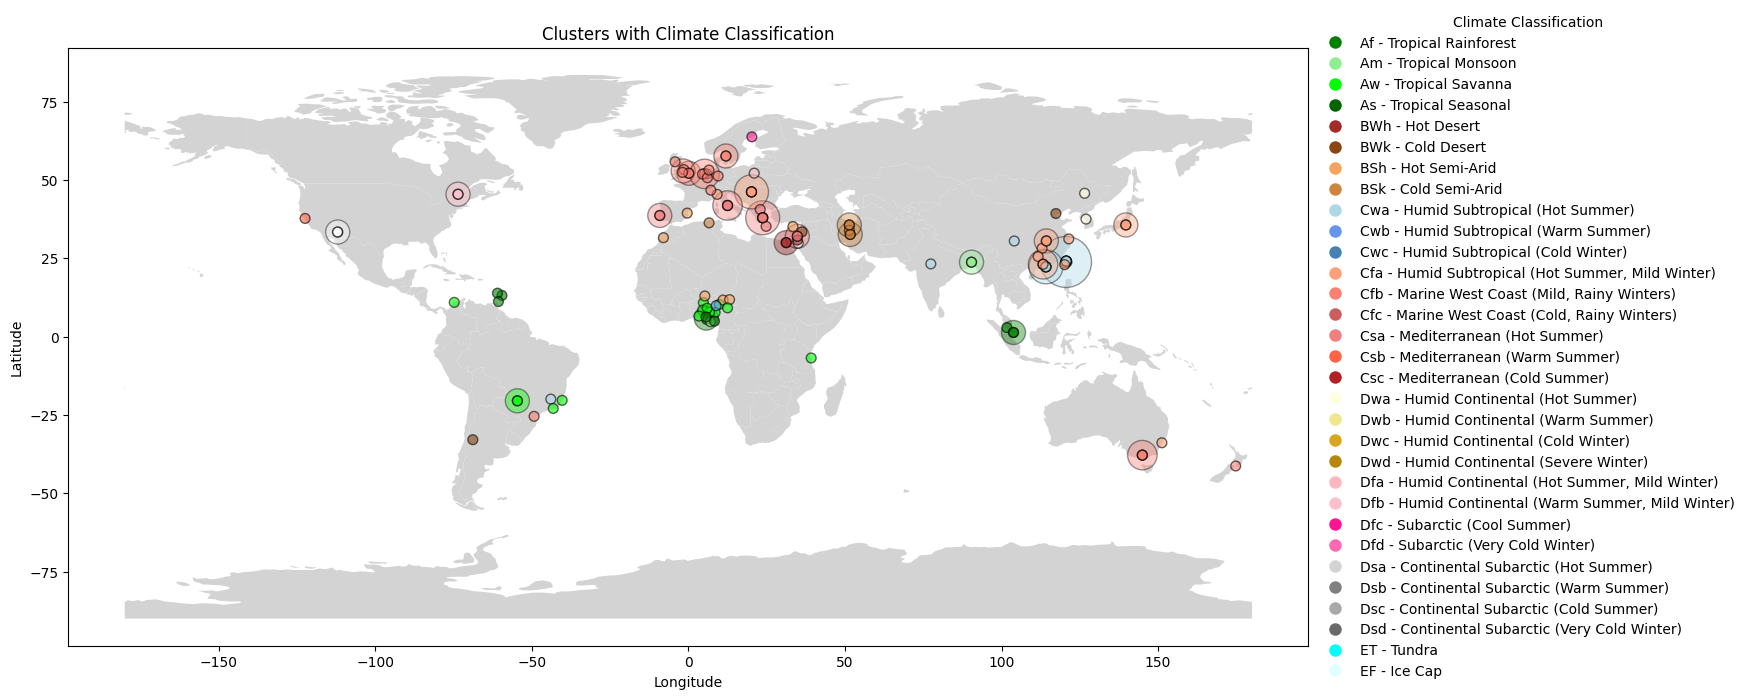

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define color mapping function
def get_color(climate):
    color_mapping = {
        'Af': 'green', 'Am': 'lightgreen', 'Aw': 'lime', 'As': 'darkgreen',
        'BWh': 'brown', 'BWk': 'saddlebrown', 'BSh': 'sandybrown', 'BSk': 'peru',
        'Cwa': 'lightblue', 'Cwb': 'cornflowerblue', 'Cwc': 'steelblue',
        'Cfa': 'lightsalmon', 'Cfb': 'salmon', 'Cfc': 'indianred',
        'Csa': 'lightcoral', 'Csb': 'tomato', 'Csc': 'firebrick',
        'Dwa': 'lightyellow', 'Dwb': 'khaki', 'Dwc': 'goldenrod', 'Dwd': 'darkgoldenrod',
        'Dfa': 'lightpink', 'Dfb': 'pink', 'Dfc': 'deeppink', 'Dfd': 'hotpink',
        'Dsa': 'lightgrey', 'Dsb': 'grey', 'Dsc': 'darkgrey', 'Dsd': 'dimgray',
        'ET': 'cyan', 'EF': 'lightcyan'
    }
    return color_mapping.get(climate, 'white')

# Apply color mapping to the DataFrame
cluster_centers['Color'] = cluster_centers['Study_climateclassification'].apply(get_color)
raw_data_df_overview_plot['Color'] = raw_data_df_overview_plot['Study_climateclassification'].apply(get_color)

#Crate a GeoDataFrame
gdf = gpd.GeoDataFrame(
    cluster_centers,
    geometry=gpd.points_from_xy(cluster_centers.Study_longitude, cluster_centers.Study_latitude)
)

gdf2 = gpd.GeoDataFrame(
    raw_data_df_overview_plot,
    geometry=gpd.points_from_xy(raw_data_df_overview_plot.Study_longitude, raw_data_df_overview_plot.Study_latitude)
)

display(gdf.head(5))
display(gdf2.head(5))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(16, 21))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
world.plot(ax=ax, color='lightgrey')

# Plot clusters with bubble sizes and colors
gdf.plot(ax=ax, color=gdf['Color'], markersize=gdf['Number_of_points']*150, alpha=0.4, edgecolor='k')
gdf2.plot(ax=ax, color=gdf2['Color'], markersize=50, alpha=0.6, edgecolor='k')

# Set plot title and labels
plt.title('Clusters with Climate Classification')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Create a legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Af - Tropical Rainforest', markersize=10, markerfacecolor='green'),
    Line2D([0], [0], marker='o', color='w', label='Am - Tropical Monsoon', markersize=10, markerfacecolor='lightgreen'),
    Line2D([0], [0], marker='o', color='w', label='Aw - Tropical Savanna', markersize=10, markerfacecolor='lime'),
    Line2D([0], [0], marker='o', color='w', label='As - Tropical Seasonal', markersize=10, markerfacecolor='darkgreen'),
    Line2D([0], [0], marker='o', color='w', label='BWh - Hot Desert', markersize=10, markerfacecolor='brown'),
    Line2D([0], [0], marker='o', color='w', label='BWk - Cold Desert', markersize=10, markerfacecolor='saddlebrown'),
    Line2D([0], [0], marker='o', color='w', label='BSh - Hot Semi-Arid', markersize=10, markerfacecolor='sandybrown'),
    Line2D([0], [0], marker='o', color='w', label='BSk - Cold Semi-Arid', markersize=10, markerfacecolor='peru'),
    Line2D([0], [0], marker='o', color='w', label='Cwa - Humid Subtropical (Hot Summer)', markersize=10, markerfacecolor='lightblue'),
    Line2D([0], [0], marker='o', color='w', label='Cwb - Humid Subtropical (Warm Summer)', markersize=10, markerfacecolor='cornflowerblue'),
    Line2D([0], [0], marker='o', color='w', label='Cwc - Humid Subtropical (Cold Winter)', markersize=10, markerfacecolor='steelblue'),
    Line2D([0], [0], marker='o', color='w', label='Cfa - Humid Subtropical (Hot Summer, Mild Winter)', markersize=10, markerfacecolor='lightsalmon'),
    Line2D([0], [0], marker='o', color='w', label='Cfb - Marine West Coast (Mild, Rainy Winters)', markersize=10, markerfacecolor='salmon'),
    Line2D([0], [0], marker='o', color='w', label='Cfc - Marine West Coast (Cold, Rainy Winters)', markersize=10, markerfacecolor='indianred'),
    Line2D([0], [0], marker='o', color='w', label='Csa - Mediterranean (Hot Summer)', markersize=10, markerfacecolor='lightcoral'),
    Line2D([0], [0], marker='o', color='w', label='Csb - Mediterranean (Warm Summer)', markersize=10, markerfacecolor='tomato'),
    Line2D([0], [0], marker='o', color='w', label='Csc - Mediterranean (Cold Summer)', markersize=10, markerfacecolor='firebrick'),
    Line2D([0], [0], marker='o', color='w', label='Dwa - Humid Continental (Hot Summer)', markersize=10, markerfacecolor='lightyellow'),
    Line2D([0], [0], marker='o', color='w', label='Dwb - Humid Continental (Warm Summer)', markersize=10, markerfacecolor='khaki'),
    Line2D([0], [0], marker='o', color='w', label='Dwc - Humid Continental (Cold Winter)', markersize=10, markerfacecolor='goldenrod'),
    Line2D([0], [0], marker='o', color='w', label='Dwd - Humid Continental (Severe Winter)', markersize=10, markerfacecolor='darkgoldenrod'),
    Line2D([0], [0], marker='o', color='w', label='Dfa - Humid Continental (Hot Summer, Mild Winter)', markersize=10, markerfacecolor='lightpink'),
    Line2D([0], [0], marker='o', color='w', label='Dfb - Humid Continental (Warm Summer, Mild Winter)', markersize=10, markerfacecolor='pink'),
    Line2D([0], [0], marker='o', color='w', label='Dfc - Subarctic (Cool Summer)', markersize=10, markerfacecolor='deeppink'),
    Line2D([0], [0], marker='o', color='w', label='Dfd - Subarctic (Very Cold Winter)', markersize=10, markerfacecolor='hotpink'),
    Line2D([0], [0], marker='o', color='w', label='Dsa - Continental Subarctic (Hot Summer)', markersize=10, markerfacecolor='lightgrey'),
    Line2D([0], [0], marker='o', color='w', label='Dsb - Continental Subarctic (Warm Summer)', markersize=10, markerfacecolor='grey'),
    Line2D([0], [0], marker='o', color='w', label='Dsc - Continental Subarctic (Cold Summer)', markersize=10, markerfacecolor='darkgrey'),
    Line2D([0], [0], marker='o', color='w', label='Dsd - Continental Subarctic (Very Cold Winter)', markersize=10, markerfacecolor='dimgray'),
    Line2D([0], [0], marker='o', color='w', label='ET - Tundra', markersize=10, markerfacecolor='cyan'),
    Line2D([0], [0], marker='o', color='w', label='EF - Ice Cap', markersize=10, markerfacecolor='lightcyan')
]

# Position legend outside the plot
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title='Climate Classification', frameon=False)


# Show plot
plt.show()

## Amount of Studies

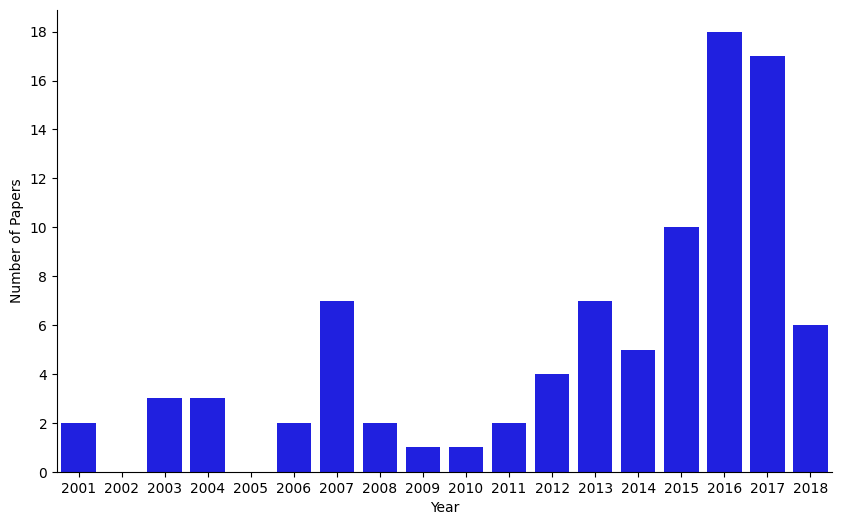

In [5]:
#TODO Stacked Barchart by studytype and main climate region (2 charts)

# Remove duplicate titles
raw_data_df = raw_data_df.drop_duplicates(subset='general_title')

# Ensure the general_date column is treated as integer (year)
raw_data_df['year'] = raw_data_df['general_date'].astype(int)

# Group by year and count the number of papers published each year
papers_per_year = raw_data_df.groupby('year').size().reset_index(name='count')

# Reindex to include all years and fill missing values with zeros
all_years = pd.DataFrame({'year': range(papers_per_year['year'].min(), papers_per_year['year'].max() + 1)})
papers_per_year = all_years.merge(papers_per_year, on='year', how='left').fillna(0)

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=papers_per_year, x='year', y='count', color='blue')

# Remove right and top spines
sns.despine(right=True, top=True)

# Sort y-axis by 2 increments
plt.yticks(range(0, int(papers_per_year['count'].max()) + 1, 2))

# Remove title
plt.title('')

# Add labels
plt.xlabel('Year')
plt.ylabel('Number of Papers')

# Show the plot
plt.show()


# Testing


Metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 360, 'height': 180, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.0, 0.0, -180.0,
       0.0, -1.0, 90.0)}

Available bands:
(1,)


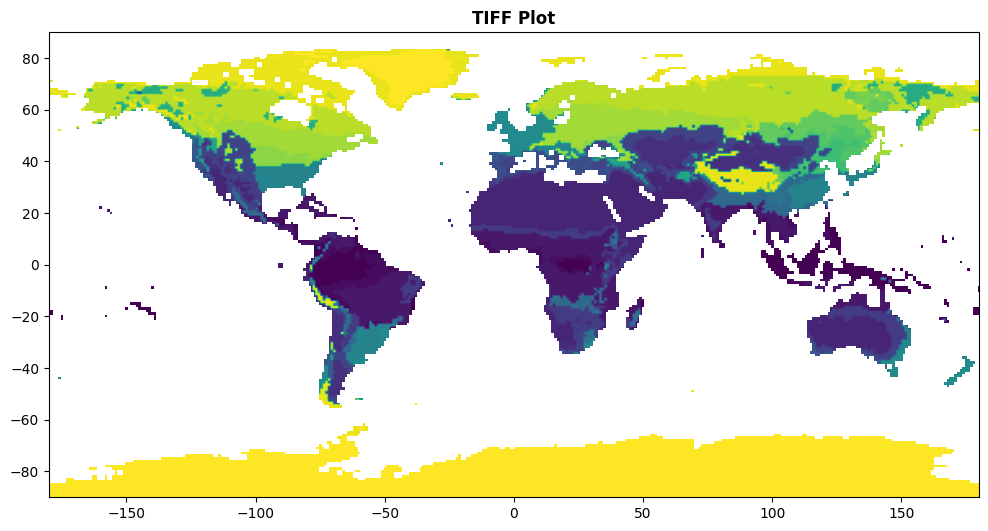

In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Replace 'path_to_your_tiff_file.tif' with the path to your TIFF file
tiff_path = r'C:\Users\gottk\Downloads\koppen_geiger_1p0.tif'

# Open the TIFF file using rasterio
with rasterio.open(tiff_path) as dataset:
    # Print metadata
    print("Metadata:")
    print(dataset.meta)
    
    # Print all available bands
    print("\nAvailable bands:")
    print(dataset.indexes)
    
    # Plot the first band
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    show(dataset, ax=ax, title='TIFF Plot')
    plt.show()


In [7]:
import rasterio
import pandas as pd
import numpy as np

# Color dictionary mapping climate classifications to colors
color_dict = {
    0: [0, 0, 255], 1: [0, 0, 255], 2: [0, 120, 255], 3: [70, 170, 250],
    4: [255, 0, 0], 5: [255, 150, 150], 6: [245, 165, 0], 7: [255, 220, 100],
    8: [255, 255, 0], 9: [200, 200, 0], 10: [150, 150, 0],
    11: [150, 255, 150], 12: [100, 200, 100], 13: [50, 150, 50],
    14: [200, 255, 80], 15: [100, 255, 80], 16: [50, 200, 0],
    17: [255, 0, 255], 18: [200, 0, 200], 19: [150, 50, 150], 20: [150, 100, 150],
    21: [170, 175, 255], 22: [90, 120, 220], 23: [75, 80, 180], 24: [50, 0, 135],
    25: [0, 255, 255], 26: [55, 200, 255], 27: [0, 125, 125], 28: [0, 70, 95],
    29: [178, 178, 178], 30: [102, 102, 102]
}

# Climate classification dictionary
climate_dict = {
    0: 'Water', 1: 'Af', 2: 'Am', 3: 'Aw', 4: 'BWh', 5: 'BWk', 6: 'BSh', 7: 'BSk',
    8: 'Csa', 9: 'Csb', 10: 'Csc', 11: 'Cwa', 12: 'Cwb', 13: 'Cwc',
    14: 'Cfa', 15: 'Cfb', 16: 'Cfc', 17: 'Dsa', 18: 'Dsb', 19: 'Dsc',
    20: 'Dsd', 21: 'Dwa', 22: 'Dwb', 23: 'Dwc', 24: 'Dwd', 25: 'Dfa',
    26: 'Dfb', 27: 'Dfc', 28: 'Dfd', 29: 'ET', 30: 'EF'
}

# Open the TIFF file using rasterio
with rasterio.open(tiff_path) as dataset:
    # Read the climate classification data
    climate_data = dataset.read(1)  # Assuming climate classification is stored in the first band
    
    # Get the geospatial coordinates
    lon, lat = np.meshgrid(np.linspace(dataset.bounds.left, dataset.bounds.right, dataset.width),
                           np.linspace(dataset.bounds.top, dataset.bounds.bottom, dataset.height))
    
    # Flatten the arrays for DataFrame creation
    lon_flat = lon.flatten()
    lat_flat = lat.flatten()
    climate_flat = climate_data.flatten()
    
    # Translate climate classification from index to string and get color
    climate_string = [climate_dict[i] for i in climate_flat]
    color = [color_dict[i] for i in climate_flat]
    
    # Create DataFrame
    df = pd.DataFrame({'Longitude': lon_flat, 'Latitude': lat_flat, 'Climate_Classification': climate_string, 'Color': color})

# Save DataFrame to CSV
csv_path = 'climate_data_with_color.csv'
df.to_csv(csv_path, index=False)

print("DataFrame saved to CSV successfully:", csv_path)

DataFrame saved to CSV successfully: climate_data_with_color.csv


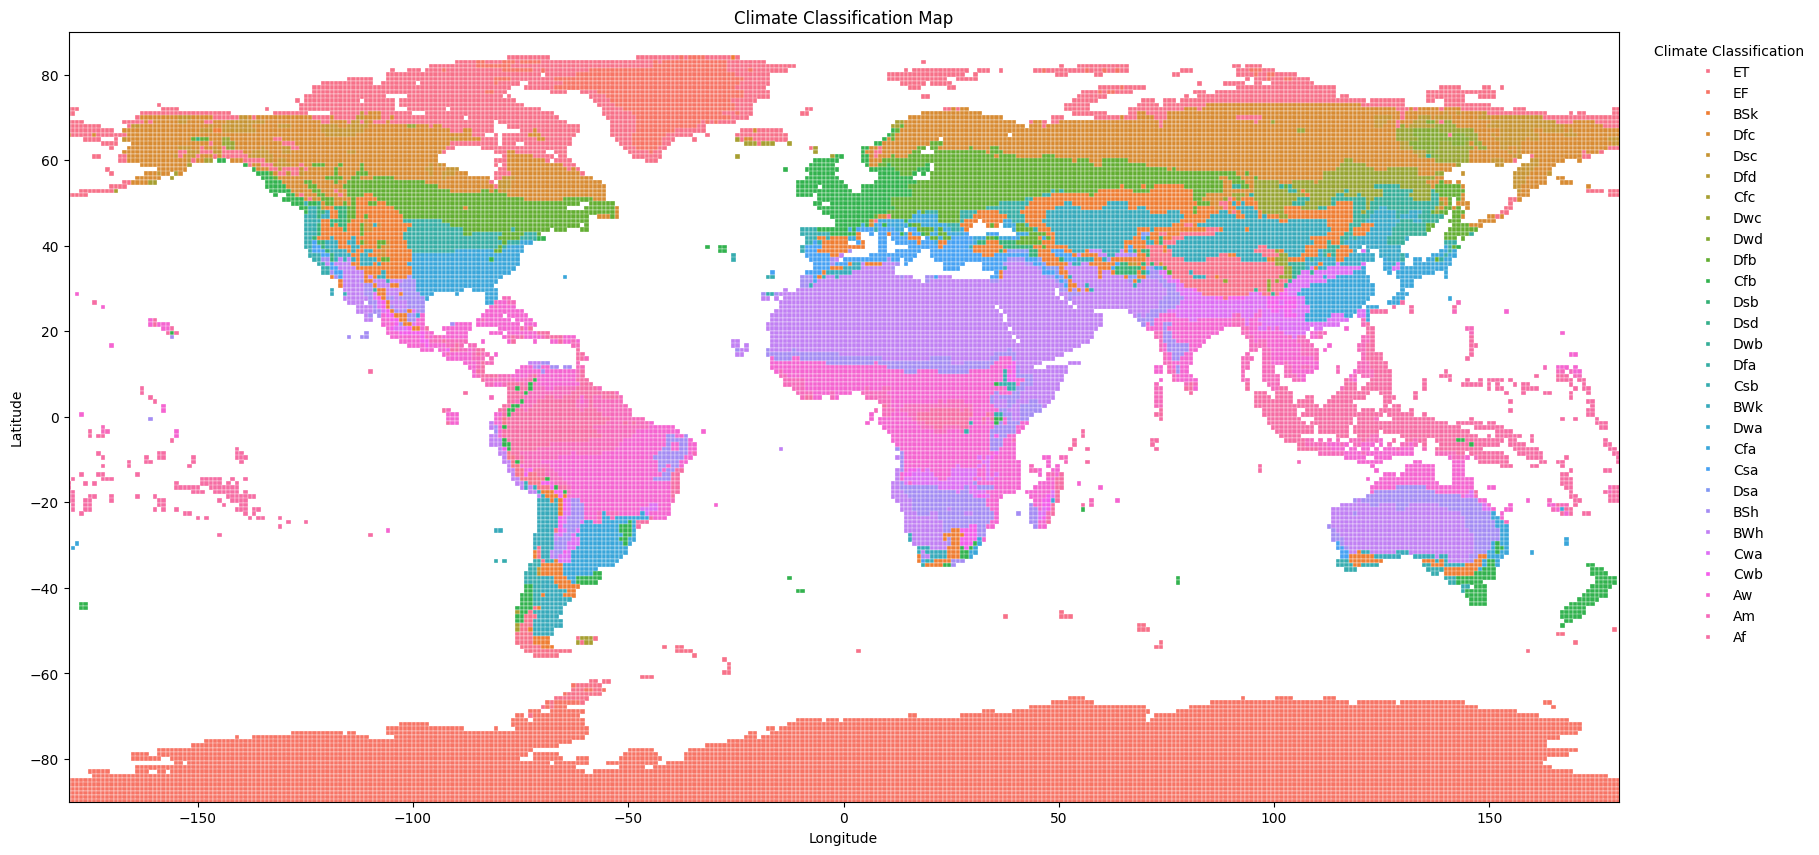

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd

# Read the CSV file into a DataFrame
csv_path = 'climate_data_with_color.csv'
df = pd.read_csv(csv_path)




# Drop rows where Climate Classification is "water"
df = df[df['Climate_Classification'] != 'Water']

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

# Create a scatterplot using Seaborn
plt.figure(figsize=(20, 10))
sns.scatterplot(data=gdf, x='Longitude', y='Latitude', hue='Climate_Classification', s=11, alpha=1, marker='s', linewidth=0.25, edgecolor='white')
plt.title('Climate Classification Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Climate Classification', bbox_to_anchor=(1.015, 1), loc='upper left', frameon=False)

plt.xlim(-180, 180)  # Example values, adjust as needed
plt.ylim(-90, 90)    # Example values, adjust as needed

plt.show()
